In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

from time import sleep

import quandl

import seaborn as sns

import sys

from scipy.stats import norm

In [2]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(ES)]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'ES'])
    

    
    return metrics 

In [3]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [4]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if sum(W) == 1:

        for i in range(len(data)):
            #port.append(initial)
            port_W.append([i / initial for i in asset])
            
            daily_ret = ((data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret #data.iloc[i]
            initial = sum(asset)
            port.append(initial)
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result, port_W)
        
    else:
        print("Weight not Equal to 1!")

In [5]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'ES'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'ES': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [6]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    th_props = [
      ('font-size', '11px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '11px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .set_table_styles(styles))
    
    return corr

# Backtesting Portfolio

TODO:
- collect data, dividned adjusted
- leverage
- start and end date

In [7]:
SP500_daily_tmp = yf.download("^SP500TR")
SHY_daily_tmp = yf.download("SHY")
TLT_daily_tmp =  yf.download("TLT")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
xls = pd.ExcelFile('/Users/davidboman/Downloads/8152748/InternationalBondReturns.xls')
sheet = "Improved_US_1947"
bond_tmp = pd.read_excel(xls, sheet)
bond_monthly = pd.DataFrame(bond_tmp['Cum Ret'])
bond_monthly.columns = ["10 Yr Bond"]
dates = pd.date_range(start = '1946-12-31', end = '2019-05-31', freq = 'M' )
bond_monthly.index = dates

In [9]:
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SHY_daily = pd.DataFrame(SHY_daily_tmp['Close'])
TLT_daily = pd.DataFrame(TLT_daily_tmp['Close'])

SP500_daily.columns = ['SP500']
SHY_daily.columns = ['SHY']
TLT_daily.columns = ['TLT']


In [ ]:
# TYX 30 yr Treasury

TYX_tmp = yf.download('^TYX')

TYX_tmp.insert(1, "TYX", 0.0, True)
ttm = 30
price = 100.0
prev_price = 0
row = 0

for i in TYX_tmp['Close']:
    TYX_tmp['TYX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
TYX = pd.DataFrame(TYX_tmp['TYX'])

In [ ]:
# TNX 10 year gov bond

TNX_tmp = yf.download('^TNX')

TNX_tmp.insert(1, "TNX", 0.0, True)
ttm = 10
price = 100.0
prev_price = 0
row = 0

for i in TNX_tmp['Close']:
    TNX_tmp['TNX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
TNX = pd.DataFrame(TNX_tmp['TNX'])

In [ ]:
# FVX 5 year gov bond

FVX_tmp = yf.download('^FVX')

FVX_tmp.insert(1, "FVX", 0.0, True)
ttm = 5
price = 100.0
prev_price = 0
row = 0

for i in FVX_tmp['Close']:
    FVX_tmp['FVX'][row] = price
    curr_price = 1/(1+i/100)**ttm
    if prev_price == 0: 
        price_change = 0
    else: 
        price_change = (curr_price-prev_price)/prev_price
    imp_yield = (price*(1+i/100)-price)/252
    price = price*(1+price_change) + imp_yield
    prev_price = curr_price
    row += 1
    
FVX = pd.DataFrame(FVX_tmp['FVX'])

In [10]:
#Gold Import
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [11]:
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_monthly = Gold.resample('M').last()
Gold.columns = ['Gold']
Gold_monthly.columns = ['Gold']

In [ ]:
Gold_monthly.index

In [12]:
#Long Vol Import
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]

In [43]:
#Monthly SP500
SP500_monthly = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="6rNSyTM5R4g7_B7XSyQW")
SP500_monthly.columns = ['SP500']
SP500_monthly.tail(600)

,SP500
Date,
1971-05-01,101.60
1971-06-01,99.72
1971-07-01,99.00
1971-08-01,97.24
1971-09-01,99.40
...,...
2020-06-01,3104.66
2020-06-30,3100.29
2020-07-01,3207.62


In [20]:
####DAILY DATA#########

data = pd.concat([SP500_daily,Gold], axis = 1) #asset_2, asset_4
data = data.ffill()
data = data.dropna()
data = data/data.shift(1)
data = data.fillna(1)

In [47]:
######## Monthly Data

data_tmp = pd.concat([SP500_monthly, Gold_monthly, bond_monthly], axis = 1)
data_tmp = data_tmp.ffill()
data_tmp = data_tmp.dropna()
monthly_data = data_tmp/data_tmp.shift()
monthly_data = monthly_data.fillna(1)
monthly_data = monthly_data.ffill()
monthly_data = monthly_data.dropna()
pd.set_option("display.max_rows", None, "display.max_columns", None)
data_tmp

,SP500,Gold,10 Yr Bond
1968-01-31,95.04,35.20,146.786810
1968-02-01,90.75,35.20,146.786810
1968-02-29,90.75,35.20,147.242982
1968-03-01,89.09,35.20,147.242982
1968-03-31,89.09,35.20,145.723846
1968-04-01,95.67,35.20,145.723846
1968-04-30,95.67,39.10,146.641386
1968-05-01,97.87,39.10,146.641386
1968-05-31,97.87,42.00,146.033449
1968-06-01,100.50,42.00,146.033449


In [41]:
rebalance_freq = 12
tol = 1
W = [1/3, 1/3, 1/3]

data_names = monthly_data.columns.tolist()


result, weights = backtest_strategy(monthly_data, W, tol, rebalance_freq, data_names, leverage = 1)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,ES
Portfolio,4.00%,6.00%,0.670000,1.000000,-23.00%,0.170000,3.30%
SP500,3.42%,9.00%,0.380000,0.310000,-51.00%,0.070000,5.00%
Gold,3.91%,13.70%,0.290000,0.330000,-62.00%,0.060000,8.00%
10 Yr Bond,3.36%,5.70%,0.590000,0.670000,-16.00%,0.210000,3.10%


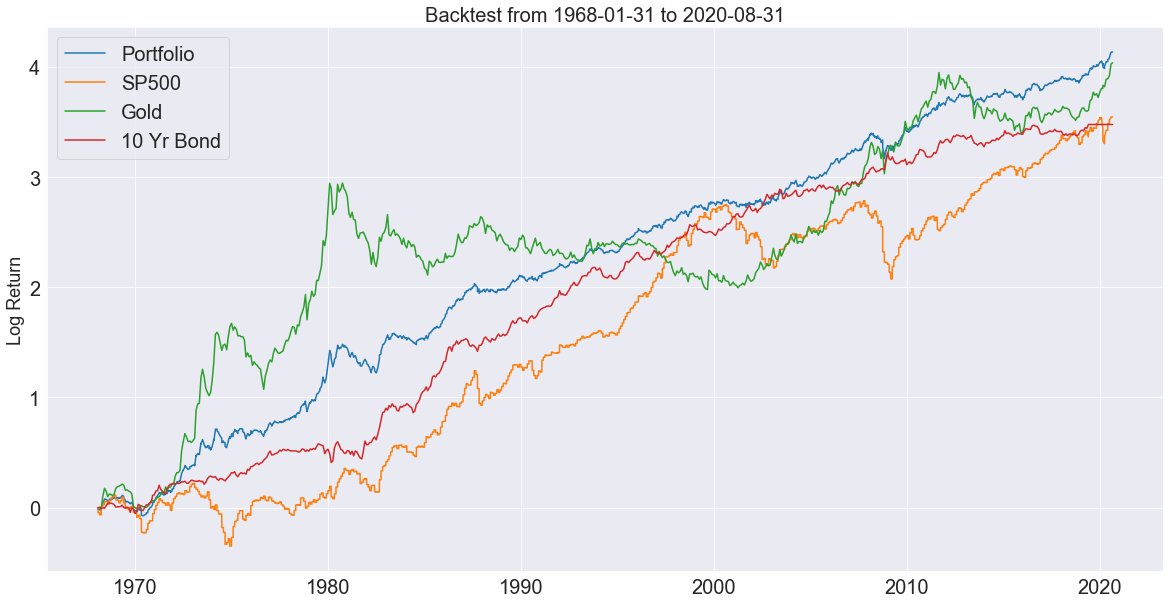

In [42]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result.columns:
    plt.plot(np.log(result[i]), label = i);

start = datetime.date(result.index.min());
end = datetime.date(result.index.max());
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.ylabel('Log Return', fontsize=18)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result, data_names, freq = 'M')


In [ ]:
correlation_map(result)